In [77]:
import numpy as np;
from tqdm import trange;
import pandas as pd;
from keras.datasets import mnist;
import sys;
from matplotlib import pyplot as plt;

In [78]:
print( "NumPy__version:", np.__version__ );
print( "Pandas__version:", pd.__version__ );

NumPy__version: 1.26.4
Pandas__version: 2.1.4


In [79]:
class Loss( object ):
    def __init__( self, name : str ):
        self.name = name;

    def __call__( self, y_pred, y_true, deriv=False ):
        if self.name == "mse" and deriv==False:
            return np.mean( ( y_pred - y_true ) ** 2 );
    
        elif self.name == "cross_entropy" and deriv==False:
            return -np.mean( y_true * np.log( y_pred ) + ( 1 - y_true ) * np.log( 1 - y_pred ) );

        elif self.name == "cross_entropy" and deriv==True:
            # Clip predictions to avoid division by zero
            #y_pred = np.clip( y_pred, 1e-15, 1 - 1e-15)

            # Compute the derivative of the binary cross-entropy loss
            #N = y_true.shape[0]
            
            derivative = ( y_pred - y_true ) / ( y_pred * ( 1 - y_pred ) );
            return derivative
        
        else:
            raise ValueError( "Invalid loss function" );

In [80]:
def one_hot( Y ):
    """
    return an 0 vector with 1 only in the position correspondind to the value in Y
    """
    one_hot_Y = np.zeros( ( Y.max()+1, Y.size ) ) ;
    one_hot_Y[Y,np.arange( Y.size )] = 1; 
    return one_hot_Y;

class BackProp( object ):
    def __init__( self ) -> None:
        pass;

    def __call__( self, data : np.ndarray , labels : np.ndarray , size : int, logits : dict , trainable_variables : dict, transfer_function : callable ) -> dict:
        """
        """
        # compute gradients
        grads = {};
    
        loss_value = np.dot( 2 , logits['output'] - labels );
        dw2 = np.dot( 1/size, loss_value.dot( logits['hidden'].T ) );
        db2 = 1/size * np.sum( loss_value, 1 );

        
        dz1 = trainable_variables['W_hidden_output_layer'].T.dot( loss_value ) * transfer_function( logits['W_input_hidden_layer'], deriv=True );


        dw1 = 1/size * dz1.dot( data.T );
        db1 = 1/size * np.sum( dz1, 1 );

        grads['W_hidden_output_layer'] = dw2;
        grads['output'] = db2;
        grads['W_input_hidden_layer'] = dw1;
        grads['hidden'] = db1;

        return grads;

class GradientDescent(object):
    """
    Gradient Descent optimizer.
    """
    def __init__(self, parameters: dict):
        self.parameters = parameters;
        self.name = "Gradient Descent";
    
    def minimize( self, trainable_variables, grads ):
        """
        """
        for key in trainable_variables.keys():
            if key[0] != 'W':
                trainable_variables[key] -= self.parameters['lr'] * np.reshape( grads[key], ( self.parameters['hidden_units'],1) );
            else:
                x = self.parameters['lr'] * grads[key];
                trainable_variables[key] -= x.T;

        return trainable_variables

In [81]:
class BaseLayer( object ):
    """
    Base class for the Layer class.
    """
    def __init__( self, hyperparams : dict, name : str  ):
        """
        Constructor for the Base Layer class.

        args:
            params : dict
            node_no : int

        returns:
            None

        attributes:
            self.params : dict
            self.node_no : int

        raises:
            None

        """
        self.hyperparams = hyperparams;
        self.name = name;

    def __rshift__( self, other ):
        """
        Overwrite the right shift operator to connect the layers.

        args:
            other : object

        returns:
            None

        attributes:
            None

        raises:
            None
        """
        return NeuralNetwork( self, other );

In [82]:
class InputLayer( BaseLayer ):
    """
    Input layer for the perceptron.
    """
    def __init__( self, hyperparams : dict, name: str  ):
        """
        Constructor for the Input Layer class.

        args:
            params : dict
            node_no : int

        returns:
            None

        attributes:
            self.bias : array

        raises:
            None
        """
        super( InputLayer, self ).__init__( hyperparams, name );
        self.node_no = hyperparams['input_units'];
    
    def output( self, inputs ):
        """
        Mirror the inputs.

        args:
            inputs : array

        returns:
            array

        attributes:
            None

        raises:
            None
        """
        self.bias_add = inputs;
        self.activated = inputs;

In [83]:
class Layer( BaseLayer ):
    """
    Layer class for the perceptron.
    """
    def __init__( self, hyperparams : dict, name: str, transfer: str  ):
        """
        Constructor for the Layer class.

        args:
            name : str
            params : dict
            node_no : int
            transfer : str

        returns:
            None

        attributes:
            self.name : str
            self.transfer : str
            self.inputs : object
            self.outputs : object

        raises:
            None
        """
        super( Layer, self ).__init__( hyperparams, name );
        self.transfer_name = transfer;

        self.inputs = None;
        self.outputs = None;
    
        if "hidden" in name:
            self.node_no = hyperparams['hidden_units'];
        else:
            self.node_no = hyperparams['output_units'];
        
        #create self.bias to be an array of size node_no with random values from a normal distribution between -1 and 1
        self.bias = np.random.rand( hyperparams['hidden_units'], hyperparams['examples']) - 0.5;
        

    def transfer_fx( self, inputs, deriv=False ):
        """
        Transfer function for the layer.

        args:
            inputs : array

        returns:
            array

        attributes:
            None

        raises:
            None
        """
        if self.transfer_name == "relu":
            if deriv == True:
                return inputs > 0;
            else:
                return np.maximum( 0,inputs );
    
        if self.transfer_name == 'softmax' and deriv == False:
            exp = np.exp( inputs - np.max( inputs ) );
            return exp / exp.sum( axis=0 );
            
        if self.transfer_name == "sigmoid":
            f_x = 1 / ( 1 + np.exp( -inputs ) );
            if deriv == True:
                return f_x * ( 1 - f_x );
            else:
                return f_x;


    def output( self, inputs, deriv=False ):
        """
        Calculate the output with the activation function and inputs.

        args:
            inputs : array

        returns:
            array

        attributes:
            self.outputs : array

        raises:
            None
        """
        self.bias_add = inputs + self.bias;
        if deriv == True:
            self.activated = self.transfer_fx( self.bias_add, deriv=True );
        else:
            self.activated = self.transfer_fx( self.bias_add );

In [84]:
class WeightLayer( BaseLayer ):
    """
    Weight layer for the perceptron.
    """
    
    def __init__( self, src : Layer, dest : Layer ) -> None:
        """
        Constructor for the weight layer.

        args:
            params : dict
            src : Layer
            dest : Layer

        returns:
            None

        attributes:
            self.src : Layer
            self.dest : Layer
            self.input_size : tuple
            self.output_size : tuple
            self.name : str
            self.weights : array

        raises: 
            None
        """
        self.src = src;
        self.dest = dest;
    
        self.weights = np.random.rand(self.src.node_no, self.dest.bias.shape[0]) - 0.5;

        self.name    = "W_%s_%s_layer" % ( self.src.name, self.dest.name );

        self.src.outputs = self;
        self.dest.inputs = self;


    def output( self, inputs ):
        """
        Matrix multiplication between the inputs and the weights.

        args:
            inputs : array

        returns:
            array

        attributes:
            None

        raises:
            None
        """
        self.src.output( inputs );
        return self.src.bias_add, self.src.activated, self.weights.T.dot( self.src.activated );

In [85]:
class NeuralNetwork( object ):
    """
    This class respresents a Neural Networks.
    """
    
    def __init__( self, layer0, layer1 ):
        """
        Constructor for the Neural Network class.
        Creates a network with an input layer, layer0 and an output layer, layer1.

        args:
            layer0 : object
            layer1 : object

        returns:
            None

        attributes:
            self.hyperparams          : ( dict ) hyperparameters for the network.
            self.layers               : ( list ) list of layers in the network.
            self.layer_name           : ( list ) list of names of the layers in the network.
            self.input_layer          : ( object ) input layer of the network.
            self.output_layer         : ( object ) output layer of the network.
            self.weights              : ( list ) list of weights in the network.
            self.weight_names         : ( list ) list of names of the weights in the network.
            self.loss_fn              : ( object ) loss function for the network.
            self.optimizer            : ( object ) optimizer for the network.
            self.learnable_parameters : ( dict ) dictionary of learnable parameters in the network.

        raises:
            None 
        """
        # hyperparameters dictionary
        self.hyperparams = layer0.hyperparams;

        # layers
        self.layers = [ layer0, layer1 ];
        self.layer_name = [ layer0.name, layer1.name ];
        self.input_layer = layer0;
        self.output_layer = self.layers[-1];

        # weights
        self.weights = [ WeightLayer( layer0, layer1 ) ];
        self.weight_names = [ self.weights[0].name ];

        # loss function
        self.loss_fn = None;

        # optimizer
        self.optimizer = None;

        # initialize and populate learnable parameters used for learning
        self.trainable_parameters = {};
        for weight in self.weights:
            self.trainable_parameters[weight.name] = weight.weights;
        for layer in self.layers[1:]:
            self.trainable_parameters[layer.name] = layer.bias;

    
    def summary( self ):
        """
        Print the summary of the network.

        args:
            None

        returns:
            None

        attributes:
            None

        raises:
            None
        """
        print( "-------" );
        print( "| Summary |" );
        print( "-------" );
        print( f"Input Layer: { self.input_layer.node_no }" );
        print( f"Hidden Layer: { self.layers[1].node_no }" );
        print( f"Output Layer: { self.output_layer.node_no }" );
    
        print( "-------" );
        print( "| Weights |" );
        print( "-------" );
        for weight_obj in self.weights:
            print( f"{weight_obj.name}: \n {weight_obj.weights} , {weight_obj.weights.shape}" );
        
        print( "-------" );
        print( "| Bias |" );
        print( "------" );
        for layer_obj in self.layers:
            if hasattr( layer_obj, 'bias' ):
                print( f"{layer_obj.name}: \n {layer_obj.bias}, {layer_obj.bias.shape}" );
            else:
                print( f"{layer_obj.name}: " );
        
        print( "---------------" );
        print( "| Hyperparameters |" );
        print( "---------------" );
        print( f"Epochs: {self.hyperparams['epochs']}" );
        print( f"Learning Rate: {self.hyperparams['lr']}" );
        print( f"Minibatch Size: {self.hyperparams['minibatch_size']}" );
        print( "---------------" );

        print( "---------------" );
        print( f"| Loss Function | : {self.loss_fn.name}" );
        print( "---------------" );
        
        print( "---------------" );
        #print( f"| Optimizer | : {self.optimizer.name}" );
        print( "---------------" );

        print( "---------------" );
        print( "| Trainable Parameters | ")
        print( "---------------" );
        print( self.trainable_parameters );
    

    def __rshift__( self, other ):
        """
        Overwrite the right shift operator to add a layer to the network
        """
        if isinstance( other, Layer ) or isinstance( other, InputLayer ):
            # add weights between the layers, append the weight name to the list
            self.weights.append( WeightLayer( self.layers[-1], other ) );
            self.weight_names.append( self.weights[-1].name );
            
            # add the layer to the network, set the output layer to the last layer, and append the layer name to the list
            self.layers.append( other );
            self.output_layer = self.layers[-1];
            self.layer_name.append( other.name );

            # add the weights and biases to the trainable parameters
            self.trainable_parameters[self.weights[-1].name] = self.weights[-1].weights;
            self.trainable_parameters[other.name] = other.bias;

            return self;
    
        if isinstance( other, Loss ):
            self.loss_fn = other;
            return self;

        if isinstance( other, GradientDescent ):
            self.optimizer = other;
            return self;

        else:
            print( type( other ) );

    def output( self, inputs ):
        """
        Calculate the output of the network.

        args:
            inputs : array

        returns:
            array

        attributes:
            None

        raises:
            None
        """
        return self.output_layer.output( inputs );

    def forward( self, inputs ):
        """
        Forward pass through the network.

        args:
            inputs : array

        returns:
            None

        attributes:
            None

        raises:
            None
        """
        fwd_output = {};

        for i in range( len( self.weights ) ):
            src_bias_add, src_activated, inputs = self.weights[i].output( inputs );
            
            fwd_output[self.weights[i].name] = inputs;
            if self.layers[i].name == 'input':
                continue;
            fwd_output[self.layers[i].name] = src_activated;
            fwd_output[self.layers[i].name + "_bias_add"] = src_bias_add;
        
        self.output( inputs );
        fwd_output['output'] = self.output_layer.activated;
        fwd_output['output_bias_add'] = self.output_layer.bias_add;
        
        return fwd_output;

    def predict( self, X ):
        """
        Predict the output of the network.

        args:
            X : array

        returns:
            array

        attributes:
            None

        raises:
            None
        """
        logits = self.forward( X );
        return np.argmax( logits['output'], 0 );

    def get_accuracy( self, predictions, Y ):
        return np.sum( predictions == Y )/Y.size

    def train( self, X, y ):
        """
        Train the network.

        args:
            X : array
            y : array
            epochs : int
            lr : float

        returns:
            None

        attributes:
            None

        raises:
            None
        """

        """
        self.losses_pd = pd.DataFrame( columns = ['fwd_losses'], index=[0] );
        self.weights_pd = pd.DataFrame();
        self.bias_pd = pd.DataFrame();
        self.weight_layer_output_pd = pd.DataFrame();
        self.activated_pd  = pd.DataFrame();
        self.grad_pd = pd.DataFrame();

        for i in range( len( self.weights ) ):
            weights = self.weights[i];
            for l in range ( weights.weights.shape[0] ):
                for j in range( weights.weights.shape[1] ):
                    self.weights_pd.loc[ 0 ,  weights.name + f"{l}_{j}" ] = weights.weights[l][j];
        
        for i in range( len( self.layers ) ):
            layer = self.layers[i];
            if hasattr( layer, 'bias' ):
                for j in range( layer.bias.shape[0] ):
                    self.bias_pd.loc[ 0, layer.name + f"{j}" ] = layer.bias[j];
        
        
        #print( self.weights_pd )
        #print( self.bias_pd )
        """
        one_hot_labels = one_hot( y )
        size = y.size;

        for epoch in range( self.hyperparams['epochs'] ):
  
            # forward pass
            fwd_outputs = self.forward( X );

            #for item in fwd_outputs:
                #print( item, fwd_outputs[item].shape );

            # logging
            #for name in self.weight_names:
                #for i in range( fwd_outputs[name].shape[0] ):
                    #for j in range( fwd_outputs[name].shape[1] ):
                        #self.weight_layer_output_pd.loc[ 0, name + f"{i}_{j}" ] = fwd_outputs[name][i][j];
                
            #for name in self.layer_name[1:]:
                #for i in range( fwd_outputs[name].shape[0] ):
                    #for j in range( fwd_outputs[name].shape[1] ):
                       # self.activated_pd.loc[ 0, name + f"{i}_{j}" ] = fwd_outputs[name][i][j];
        

            # backward pass
            grads = BackProp()( X, one_hot_labels, size, fwd_outputs, self.trainable_parameters, self.layers[1].transfer_fx );
            
            # update the weights
            self.trainable_parameters = self.optimizer.minimize( self.trainable_parameters, grads );

            # update the weights and biases
            for weight in self.weights:
                weight.weights = self.trainable_parameters[weight.name];

            for layer in self.layers[1:]:
                layer.bias = self.trainable_parameters[layer.name];


            if ( epoch+1 ) % int( self.hyperparams['epochs']/10 ) == 0:
                print(f"Iteration: {epoch+1} / {self.hyperparams['epochs']}")
                prediction = self.predict( X );
                print(f'{self.get_accuracy(prediction, y):.3%}')


In [86]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
SCALE_FACTOR = 255 # TRES IMPORTANT SINON OVERFLOW SUR EXP
WIDTH = x_train.shape[1]
HEIGHT = x_train.shape[2]
x_train = x_train.reshape(x_train.shape[0],WIDTH*HEIGHT).T / SCALE_FACTOR
x_test = x_test.reshape(x_test.shape[0],WIDTH*HEIGHT).T  / SCALE_FACTOR

print( x_train.shape )

(784, 60000)


In [87]:
params = {
    #seed
    "seed" : 42,

    "examples" : x_train.shape[1],
    
    # model hyperparameters
    "input_units" : x_train.shape[0],
    "hidden_units" : 10,
    "output_units" : 1,

    # optimizer hyperparameters
    "lr" : 0.15,

    # training hyperparameters
    "epochs" : 350,
    "minibatch_size" : 4
}
#np.random.seed(params['seed']);

In [88]:
input_layer = InputLayer( params, "input" );
hidden_layer = Layer( params, "hidden", "sigmoid" );
output_layer = Layer( params, "output", "softmax" );

loss = Loss( "cross_entropy" );
optimizer = GradientDescent( params );

In [89]:
nn = input_layer >> output_layer >> loss >> optimizer;

In [90]:
nn.train( x_train, y_train );

KeyError: 'hidden'

Prediction:  [5 3 3 ... 3 3 5]
Unique values:  [0 1 2 3 4 5 6 7 8 9]
Counts:  [5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]
Label:  5


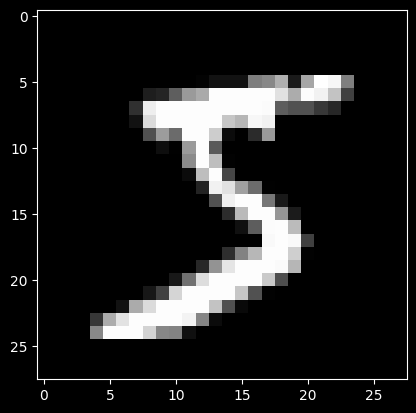

In [76]:
index = 0
vec = x_train[:, index,None]
label = y_train[index]
prediction = nn.predict(vec)

print("Prediction: ", prediction)

# get the unique values in prediction
unique, counts = np.unique(y_train, return_counts=True)
print("Unique values: ", unique)
print("Counts: ", counts)

print("Label: ", label)

current_image = vec.reshape((WIDTH, HEIGHT)) * SCALE_FACTOR

plt.gray()
plt.imshow(current_image, interpolation='nearest')
plt.show()